In [79]:
import numpy as np
import random
from dataclasses import dataclass
from tqdm.auto import tqdm
from typing import List
import itertools

In [80]:
problem = np.load('../data/problem_0.npz')
X = problem['x']
Y = problem['y']

DATA = X
LABELS = Y

print(DATA.shape)
print(LABELS.shape)
print(DATA[:,0])
print(LABELS[0])
PROBLEM_SIZE = DATA.shape[0]

NUM_TOURNAMENTS = 3
POPULATION_SIZE = PROBLEM_SIZE*20*NUM_TOURNAMENTS
OFFSPRING_SIZE = int((POPULATION_SIZE//NUM_TOURNAMENTS)*0.8)
MAX_GENERATIONS = 4000

TOURNAMENT_GENERATIONS = 400
INCREASE_COMPLEXITY_STEP = 250

(2, 1000)
(1000,)
[2.98832053 0.8905889 ]
3.1438089898863355


In [81]:
rng = np.random.Generator(np.random.PCG64(42))

In [82]:
# Operators

BINARY_OPERATORS = ["+", "-", "*", "/"]
UNARY_OPERATORS = ["sin", "cos","tan", "exp", "log","arcsin","arccos","arctan","sqrt","abs","pow"]
VARIABLES = ["X_"+str(i) for i in range(PROBLEM_SIZE)]
VARIABLES_WEIGHTS = [[1/len(VARIABLES) for _ in range(len(VARIABLES))]]
VARIABLES_MAP = {var: i for i,var in enumerate(VARIABLES)}

In [83]:
@dataclass
class Individual:
    genome: list
    fitness: tuple

In [84]:
def compute_MSE(Y_pred, Y_real):
    
    MSE = 100*np.square(Y_real-Y_pred).sum()/len(Y_real)
    return MSE

In [85]:
def compute_unary_weights(unary_operators,j,x,y):
    """
    Compute unary operators weights depending on functions dominion and relation between input and output
    """
    W = {op: 0 for op in unary_operators}

    # Funzioni di dominio
    def is_valid_tan(x,curr):
        return np.abs(np.cos(x)) > 1e-9 and curr != -1

    def is_valid_log(x,curr):
        return x > 0 and curr != -1

    def is_valid_sqrt(x,curr):
        return x >= 0 and curr != -1

    def is_valid_arcsin_arccos(x,curr):
        return -1 <= x <= 1 and curr != -1

    for i in range(x.shape[1]):  # Per ogni riga di x
        curr_x = x[j, i]
        curr_y = y[i]

        for op in unary_operators:
            if op == "sin" or op == "cos":
                if np.abs(curr_y) > 100:
                    W[op] += 2
                elif -1 <= curr_y <= 1:
                    W[op] += 5  
                else:
                    W[op] += 2

            elif op == "tan":
                if is_valid_tan(curr_x, W[op]):
                    if np.abs(curr_y) > 100:
                        W[op] += 5  
                    else:
                        W[op] += 3
                else:
                    W[op] = -1
                                
            elif op == "exp":
                if curr_y < 0 and curr_x<0:
                    W[op] +=1 
                elif np.abs(curr_y) > 100 * np.abs(curr_x):
                    W[op] += 5  
                else:
                    W[op] += 2

            elif op == "log":
                if is_valid_log(curr_x, W[op]):
                    if curr_x < 1 and curr_y < 0:
                        W[op] += 5  
                    elif curr_y < curr_x:
                        W[op] += 3  
                    else:
                        W[op] += 1
                else:
                    W[op] = -1

            elif op == "arcsin" or op == "arccos":
                if is_valid_arcsin_arccos(curr_x, W[op]):
                    if -np.pi/2 <= curr_y <= np.pi/2:
                        W[op] += 5 
                    else:
                        W[op] += 1
                else:
                    W[op] = -1

            elif op == "arctan":
                if -np.pi/2 <= curr_y <= np.pi/2:
                    W[op] += 5  
                else:
                    W[op] += 2

            elif op == "sqrt":
                if is_valid_sqrt(curr_x, W[op]):
                    if curr_y <= curr_x:
                        W[op] += 5  # lower input
                    else:
                        W[op] += 1
                else:
                    W[op] = -1
            elif op == "abs":
                if curr_y >0 and curr_x <0: 
                    W[op] += 3
                else:
                    W[op] += 1

    # Normalize weights
    WArray = [W[op] if W[op] != -1 else 0 for op in unary_operators]
    
    tot_sum = np.sum(WArray)
    if tot_sum > 0: 
        WArray = [float(w / tot_sum) for w in WArray]

    return WArray


In [86]:
UNARY_OPERATORS_WEIGHTS = [compute_unary_weights(UNARY_OPERATORS,i,DATA,LABELS) for i in range(PROBLEM_SIZE)]
UNARY_OPERATORS_MAP = {op: i for i,op in enumerate(UNARY_OPERATORS)}
BINARY_OPERATORS_WEIGHTS = [[1/len(BINARY_OPERATORS) for _ in BINARY_OPERATORS] for _ in range(PROBLEM_SIZE)]
BINARY_OPERATORS_MAP = {op: i for i,op in enumerate(BINARY_OPERATORS)}

### Genetic Program Logic

We have to find a combination of X (numpy array for data of size (n,m)) with numpy operands that gives as result Y (numpy array for labels of size (m,)). <br>
Each formula (genome) will have the form: 
<br><br>
_0 Opb,1 A * Opu,1(X1*Av) Opb,2 B * Opu,2(X2*Bv) ... Opb,i I * Opu,i(Xi*Iv) ...Opb,n N * Opu,n(Xn*Nv)_

- n: Problem size
- Xi: Variable of col i for each row data sample
- A, B, ..I, ..N: costants positive or negative that works as weights for the single term
- Av, Bv, ..Iv, ..Nv: positive constants that wights only the single variable 
- Opu,n(..): unary operators for one variable
- Opb,n: binary operators between two terms

If the fitness doesn't improve for a fixed number of generation a generic term is added, increasing the complexity to _(prev_n + 1)_ 

Example of formula expression for 2 variable problem:
["1", "", "1", "X_0", "+", "0.2", "sin","1", "X_1", "+"]

In [87]:
UNARY_OPERATIONS = {
        "": lambda x: x,
        "sin": np.sin,
        "cos": np.cos,
        "tan":np.tan,
        "log": np.log,
        "exp": np.exp,
        "arccos": np.arccos,
        "arcsin":np.arcsin,
        "arctan":np.arctan,
        "sqrt":np.sqrt,
        "abs":np.abs
    }

In [88]:
def compute_FX(F, X, Y):
    # Number of terms
    num_terms = len(F) // 5

    # Pre-compute fixed F values
    coefficients = np.array([float(F[5 * i]) for i in range(num_terms)])
    variable_costs = np.array([float(F[2 + 5 * i]) for i in range(num_terms)])
    columns = np.array([int(F[3 + 5 * i].split("_")[1]) for i in range(num_terms)])
    operations = [F[1 + 5 * i] for i in range(num_terms)]
    operators = [F[4 + 5 * i] for i in range(num_terms)]

    # Map unary operations
    unary_funcs = [UNARY_OPERATIONS[op] for op in operations]

    # Extract the specific columns from X and apply variable costs
    X_selected = X[columns, :]  # Shape: (num_terms, num_rows)
    X_transformed = X_selected * variable_costs[:, np.newaxis]  # Broadcasting

    # Apply unary functions (broadcasting over rows)
    for i, func in enumerate(unary_funcs):
        X_transformed[i, :] = func(X_transformed[i, :])

    # Multiply by coefficients
    T = coefficients[:, np.newaxis] * X_transformed  # Shape: (num_terms, num_rows)

    # Apply the operators
    Y_pred = np.zeros(X.shape[1])
    for i, op in enumerate(operators):
        if op == "+":
            Y_pred += T[i, :]
        elif op == "-":
            Y_pred -= T[i, :]
        elif op == "*":
            Y_pred *= T[i, :]
        elif op == "/":
            Y_pred /= np.where(T[i, :] != 0, T[i, :], 1)  # Avoid division by zero

    # Metrics
    mse = compute_MSE(Y_pred, Y)
    diff_abs = np.abs(Y_pred) - np.abs(Y)
    increase = np.mean(diff_abs) < 0
    inc_dec_factor = np.mean(diff_abs)
    right_sign = np.all((Y_pred > 0) == (Y > 0))
    count_right_sign = np.sum((Y_pred > 0) == (Y > 0))

    return mse, increase, right_sign, count_right_sign, inc_dec_factor


In [89]:
def new_term(individual_gen:List,n,y):
    # i = 0
    costant = 1
    if np.any(y<0) and rng.random()<0.5: costant*=-1
    individual_gen.append(costant)

    # i = 3
    var = rng.choice(VARIABLES,1 ,p=VARIABLES_WEIGHTS[0]) [0] 
    VARIABLES_WEIGHTS[0][VARIABLES_MAP[var]] = 0.1
    VARIABLES_WEIGHTS[0] /= np.sum(VARIABLES_WEIGHTS[0])

    # i = 1
    unary_op = "" if rng.random() < 0.2 else str(rng.choice(UNARY_OPERATORS,1,p=UNARY_OPERATORS_WEIGHTS[int(var.split("_")[1])])[0])
    individual_gen.append(unary_op)

    # i = 2
    var_costant = 1 # the costant that multiply the variable start from 1
    individual_gen.append(var_costant)
    
    individual_gen.append(var)

    # i = 4
    bin_op = rng.choice(BINARY_OPERATORS,1) if n !=0 else rng.choice(["+","-"],1)
    individual_gen.append(str(bin_op[0]))

    return individual_gen

In [90]:
def generate_individual(x,y,max_depth=PROBLEM_SIZE)->Individual:
    individual_gen = []
    for n in range(max_depth):

        individual_gen = new_term(individual_gen,n,y)

    mse, _, right_sign, count, _ = compute_FX(individual_gen,x,y)    
    return Individual(individual_gen,(right_sign,-mse,count))

In [91]:
def add_term(population,terms_added, x,y):
    new_population = []
    for ind in population:
        new_genome = new_term(ind.genome.copy(),PROBLEM_SIZE+terms_added,y)
        mse, _, right_sign, count, _  = compute_FX(ind.genome,x,y) 
        new_fitness = (right_sign,-mse,count) 
        new_population.append(Individual(new_genome,new_fitness))
    return new_population

In [92]:
def parent_selection(population):
    # parent selection by rank, using a half fitness hole to prevent overfitting
    # e.g. first individual with rank 0 will have higher probability to be chosen
    rank_probs = [(len(population)-i-1)/sum(range(len(population))) for i in range(len(population))]
    
    if rng.random()<0.5:
        # best by mse (population is already sorted by mse)
        candidates = rng.choice(population, 5, replace=False, p = rank_probs)
    else:
        # best by right-sign count
        best_by_right_sign = sorted(population, key=lambda i: i.fitness[2], reverse=True)
        candidates = rng.choice(best_by_right_sign, 5, replace=False, p= rank_probs)
    
    selected_parents = rng.choice(candidates, 2, replace=False)

    return selected_parents

In [93]:
def survival_selection(population):
    # Rank based selection + fitness hole based on right-sign count
    new_population = []
    new_genomes = []
    for i in range(POPULATION_SIZE//NUM_TOURNAMENTS):
        if population[i].genome not in new_genomes:
            new_population.append(population[i])
            new_genomes.append(population[i].genome)
            if len(new_population) == (POPULATION_SIZE//NUM_TOURNAMENTS)//2:
                break
    population = sorted(population,key=lambda x : x.fitness[2],reverse=True)
    for i in range(POPULATION_SIZE//NUM_TOURNAMENTS):
        if population[i].genome not in new_genomes:
            new_population.append(population[i])
            new_genomes.append(population[i].genome)
            if len(new_population) == POPULATION_SIZE//NUM_TOURNAMENTS:
                break
    
    return new_population


In [94]:
def update_weights(genome, sync_factor, increase: bool):
    
    for i in range(len(genome) // 5):
        unary_term = genome[1 + 5 * i]
        binary_term = genome[4 + 5 * i]
        n_var = int(genome[3 + 5 * i].split("_")[1])  # Numero della variabile

        # Aggiorna i pesi per gli operatori unari
        if unary_term != "":
            unary_idx = UNARY_OPERATORS_MAP[unary_term]
            if increase:
                UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] += sync_factor if UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] <= 0.65 else 0
            else:
                UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] -= sync_factor if UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] >= 0.15 else 0
            # Normalizza i pesi
            UNARY_OPERATORS_WEIGHTS[n_var] /= np.sum(UNARY_OPERATORS_WEIGHTS[n_var])

        # Aggiorna i pesi per gli operatori binari
        binary_idx = BINARY_OPERATORS_MAP[binary_term]
        if increase:
            BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] += sync_factor if BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] <= 0.65 else 0
        else:
            BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] -= sync_factor if BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] >= 0.15 else 0
        # Normalizza i pesi
        BINARY_OPERATORS_WEIGHTS[n_var] /= np.sum(BINARY_OPERATORS_WEIGHTS[n_var])


In [95]:
def xover(p1: Individual, p2: Individual, x, y) -> Individual:
    ''' Exchange terms between two individuals '''
    # Divide genomes into blocks
    blocks1 = [p1.genome[i:i + 5] for i in range(0, len(p1.genome), 5)]
    blocks2 = [p2.genome[i:i + 5] for i in range(0, len(p2.genome), 5)]
    if len(blocks1) != len(blocks2): print("error")
    child_genome = p1.genome.copy()
    new_fitness = ()
    right_sign = p1.fitness[0] or p2.fitness[0]

    rep_factor = 0
    while rep_factor<0.5:
        sync_factor = 0.03 if right_sign else 0.01
        # Select random blocks to exchange
        xover_blocks = rng.choice(range(len(blocks1)), rng.integers(0.5, len(blocks1)), replace=False)

        # Exchange blocks
        for b_i in xover_blocks:
            #print(f"i_xo: {np.where(np.array(blocks1)==blocks2[b_i][3])}")
            i_xo = np.where(np.array(blocks1)==blocks2[b_i][3])[0]
            i_xo = i_xo[0] if len(i_xo)>0 else b_i
            blocks1[i_xo] = blocks2[b_i]

        # Rebuild child genome
        child_genome = [elem for block in blocks1 for elem in block]

        # Evaluate fitness
        new_mse, _, right_sign, count, _ = compute_FX(child_genome, x, y)
        new_fitness = (right_sign, -new_mse, count)

        # Update weights based on fitness
        if new_fitness > p1.fitness or new_fitness > p2.fitness:
            update_weights(child_genome, sync_factor, increase=True)
            break
        else:
            update_weights(child_genome, sync_factor, increase=False)
        
        rep_factor = rng.random()

    return Individual(child_genome, new_fitness)


In [96]:
def adjust_mutation_factor(mutation_factor, increase):
    if increase: 
            mutation_factor= 1.1 #if mutation_factor >=1 else 1.2
    else: 
        mutation_factor= 0.9 #if mutation_factor <=1 else 0.8
    return mutation_factor

In [97]:
def mutation_unary_coeff(op,curr_coeff,reset=False):
    eps = 1e-9
    
    if op == "sin" or op == "cos" or op == "tan":  
        return rng.choice(rng.uniform(-np.pi/2 + eps,np.pi/2,100),1)[0]

    elif op == "exp" or op == "log" or op == "arctan" or op == "sqrt" or op == "abs" or op == "sqrt" or op == "":
        return curr_coeff*1.2 if not reset else 1

    elif op == "arcsin" or op == "arccos":  
        return rng.choice(rng.uniform(-1 + eps,1,100),1)[0]
    
    else:
        return 1

In [98]:
def mutation(p: Individual, mutation_factor: float ,x, y) :
    ''' Mutate terms of one individual '''
    child_genome = p.genome.copy()
    new_fitness = ()
    blocks = [child_genome[i:i + 5] for i in range(0, len(child_genome), 5)]
    right_sign = p.fitness[0]
    rep_factor=0
    
    while rep_factor<0.6:
        sync_factor = 0.05 if right_sign else 0.01
        # Define mutation probabilities
        mutation_probs = np.array([0.2, 0.3, 0.2, 0, 0.3]) if right_sign else np.array([0.25, 0.25, 0.25, 0, 0.25])

        # Select random blocks to mutate
        if len(blocks) == 1:
            mutate_blocks = [0]
        else:
            mutate_blocks = rng.choice(range(len(blocks)), rng.integers(1, len(blocks)), replace=False)

        for b_i in mutate_blocks:
            # Mutate elements in the block
            elems = rng.choice(5, size=rng.integers(1, 5), p=mutation_probs)
            n_var = int(blocks[b_i][3].split("_")[1])

            for e_i in elems:
                if e_i == 0:
                    blocks[b_i][e_i] *= mutation_factor #if blocks[b_i][e_i] < 1e4 else rng.random()
                    if not right_sign: blocks[b_i][e_i]*=-1
                elif e_i == 1:
                    new_unary_op = "" if rng.random() < 0.15 else str(rng.choice(UNARY_OPERATORS,1,p=UNARY_OPERATORS_WEIGHTS[n_var])[0])
                    blocks[b_i][2] = mutation_unary_coeff(blocks[b_i][e_i],blocks[b_i][2],new_unary_op != blocks[b_i][e_i])

                    blocks[b_i][e_i] = new_unary_op
                 
                elif e_i == 2 and blocks[b_i][1] not in ["arccos","arcsin","arctan"]:
                    blocks[b_i][e_i] = mutation_unary_coeff(blocks[b_i][1],blocks[b_i][e_i])

                elif e_i == 4:
                    new_bin_op = rng.choice(BINARY_OPERATORS,1,p=BINARY_OPERATORS_WEIGHTS[n_var]) if b_i !=0 else rng.choice(["+","-"],1)
                    blocks[b_i][e_i] = str(new_bin_op[0])  
                else:
                    continue

        # Rebuild genome and compute fitness
        child_genome = [elem for block in blocks for elem in block]
        new_mse, increase, right_sign, count, inc_factor = compute_FX(child_genome, x, y)
        new_fitness = (right_sign, -new_mse, count)

        if new_fitness > p.fitness:
            update_weights(child_genome, sync_factor, increase=True)
            break
        else:
            update_weights(child_genome, sync_factor, increase=False)

        # Adjust mutation factor
        mutation_factor = adjust_mutation_factor(mutation_factor, increase)

        rep_factor = rng.random()

    return Individual(child_genome, new_fitness), mutation_factor

In [99]:
def EA_resolution(num_generations, population,x,y,increase_complexity=False):
    history = []
    mutation_factor = 1
    n_no_improvement = 0
    terms_added = 0
    champion = population[0]
    for i in tqdm(range(num_generations)):

        offspring = list()

        for _ in range(OFFSPRING_SIZE):
            
            p1,p2 = parent_selection(population)
            
            if rng.random() <0.5 and not champion.fitness[0]:
                o = xover(p1,p2,x,y)
            else:
                o,mutation_factor = mutation(p1,mutation_factor,x,y)

            offspring.append(o)

        population.extend(offspring)

        population = sorted(population, key=lambda i: i.fitness,reverse=True)
        population = survival_selection(population)
        

        if population[0].fitness > champion.fitness:
            champion = population[0]
            n_no_improvement = 0
        else:
            n_no_improvement += 1
        
        if increase_complexity:
            if n_no_improvement > INCREASE_COMPLEXITY_STEP :
                if terms_added == 3:
                    break
                print("\t\tChanging population")
                population = add_term(population,terms_added,x,y)
                population.sort(key=lambda i: i.fitness,reverse=True)
                terms_added +=1
                n_no_improvement = 0
                print(f"\t\tNew problem complexity: {PROBLEM_SIZE+terms_added}")
            elif n_no_improvement == INCREASE_COMPLEXITY_STEP-10:
                # to prevent overfitting, before increasing problem complexity try to reset weights
                print("\t\tReset weights")
                for i in range(PROBLEM_SIZE):
                    UNARY_OPERATORS_WEIGHTS[i] = compute_unary_weights(UNARY_OPERATORS,i,DATA,LABELS) 
                    BINARY_OPERATORS_WEIGHTS[i] = [1/len(BINARY_OPERATORS) for _ in BINARY_OPERATORS]
            
        history.append(population[0])

        if i % 250 == 0 and i!= 0:
            print(f"\t\tBest individual found at iteration {i}:")
            print(f"\t\t\t{champion.genome}")
            print(f"\t\t\t{champion.fitness}")
        
        if -champion.fitness[1]<1e-30:
            print(f"\t\t\tEarly stopping: Near Solution Found")
            break

    return champion, history, population

In [100]:
POPULATION = [generate_individual(DATA,LABELS) for _ in range(POPULATION_SIZE)]
POPULATION = sorted(POPULATION,key= lambda x : x.fitness)
winners = []
histories = []
for i in range(NUM_TOURNAMENTS):
    TOURNAMENT_POP = POPULATION[(POPULATION_SIZE//NUM_TOURNAMENTS)*i:(POPULATION_SIZE//NUM_TOURNAMENTS)*(i+1)]
    print(f"Starting tournament n: {i+1}")
    winner, history, _ = EA_resolution(TOURNAMENT_GENERATIONS,TOURNAMENT_POP,DATA[:,(DATA.shape[1]//NUM_TOURNAMENTS)*i:(DATA.shape[1]//NUM_TOURNAMENTS)*(i+1)],LABELS[(DATA.shape[1]//NUM_TOURNAMENTS)*i:(DATA.shape[1]//NUM_TOURNAMENTS)*(i+1)])
    print(f"Winner of Tounament n: {i+1}: {winner}")
    for i in range(PROBLEM_SIZE):
            UNARY_OPERATORS_WEIGHTS[i] = compute_unary_weights(UNARY_OPERATORS,i,DATA,LABELS) 
            BINARY_OPERATORS_WEIGHTS[i] = [1/len(BINARY_OPERATORS) for _ in BINARY_OPERATORS]
            
    winners.append(winner)
    histories.append(history)

for i,w in enumerate(winners):
    mse, _, right_sign, count_right_sign, _ = compute_FX(w.genome, DATA,LABELS)
    w.fitness = (right_sign, -mse, count_right_sign)
    print(f"New fitness winner {i+1}")
    print(w.fitness)

Starting tournament n: 1


  0%|          | 0/400 [00:00<?, ?it/s]

C:\Users\loren\AppData\Local\Temp\ipykernel_19980\4065164462.py:21: RuntimeWarning: invalid value encountered in arccos
  X_transformed[i, :] = func(X_transformed[i, :])
C:\Users\loren\AppData\Local\Temp\ipykernel_19980\4065164462.py:21: RuntimeWarning: invalid value encountered in arcsin
  X_transformed[i, :] = func(X_transformed[i, :])
 64%|██████▍   | 257/400 [00:09<00:04, 30.88it/s]

		Best individual found at iteration 250:
			[-0.9900000000000001, '', 1, np.str_('X_0'), '-', 1.1740617900000008, '', np.float64(-0.15530518901404242), np.str_('X_1'), '-']
			(np.True_, np.float64(-0.03676888268988177), np.int64(333))


100%|██████████| 400/400 [00:14<00:00, 27.35it/s]


Winner of Tounament n: 1: Individual(genome=[-0.9900000000000001, '', 1, np.str_('X_0'), '-', 1.1740617900000008, '', np.float64(-0.15530518901404242), np.str_('X_1'), '-'], fitness=(np.True_, np.float64(-0.03676888268988177), np.int64(333)))
Starting tournament n: 2


 64%|██████▍   | 257/400 [00:07<00:04, 35.06it/s]

		Best individual found at iteration 250:
			[-0.5261265900000002, 'arctan', np.float64(0.3563567161859028), np.str_('X_1'), '-', 1, '', 1, np.str_('X_0'), '+']
			(np.True_, np.float64(-0.00130736970020253), np.int64(333))


100%|██████████| 400/400 [00:11<00:00, 35.21it/s]


Winner of Tounament n: 2: Individual(genome=[-0.5261265900000002, 'arctan', np.float64(0.3563567161859028), np.str_('X_1'), '-', 1, '', 1, np.str_('X_0'), '+'], fitness=(np.True_, np.float64(-0.00130736970020253), np.int64(333)))
Starting tournament n: 3


 64%|██████▎   | 254/400 [00:07<00:04, 31.57it/s]

		Best individual found at iteration 250:
			[-1, '', 1, np.str_('X_0'), '-', 0.6430436100000002, 'arctan', np.float64(-0.2921729611158308), np.str_('X_1'), '-']
			(np.True_, np.float64(-0.0020617720614210574), np.int64(333))


100%|██████████| 400/400 [00:12<00:00, 32.16it/s]

Winner of Tounament n: 3: Individual(genome=[1, '', 1, np.str_('X_0'), '+', -0.37971082126890016, 'arctan', np.float64(-0.5126283187400373), np.str_('X_1'), '+'], fitness=(np.True_, np.float64(-0.0013161256718834536), np.int64(333)))
New fitness winner 1
(np.True_, np.float64(-0.03702698120257322), np.int64(1000))
New fitness winner 2
(np.True_, np.float64(-0.0014884704868466663), np.int64(1000))
New fitness winner 3
(np.True_, np.float64(-0.0013711472694701366), np.int64(1000))


In [101]:
print("Generating new competitors")
NEW_POPULATION = []
NEW_POPULATION.extend(winners)
#NEW_POPULATION.extend(POPULATION)
print(NEW_POPULATION)
while len(NEW_POPULATION) != POPULATION_SIZE:
    p = rng.choice(winners,1)[0]
    child, _ = mutation(p,1,DATA,LABELS)
    NEW_POPULATION.append(child)
print(len(NEW_POPULATION))
print("Starting final Tournament")
winner, history, _ = EA_resolution(MAX_GENERATIONS,NEW_POPULATION,DATA,LABELS,True)
print(f"Winner of Final Tounament : {winner}")

Generating new competitors
[Individual(genome=[-0.9900000000000001, '', 1, np.str_('X_0'), '-', 1.1740617900000008, '', np.float64(-0.15530518901404242), np.str_('X_1'), '-'], fitness=(np.True_, np.float64(-0.03702698120257322), np.int64(1000))), Individual(genome=[-0.5261265900000002, 'arctan', np.float64(0.3563567161859028), np.str_('X_1'), '-', 1, '', 1, np.str_('X_0'), '+'], fitness=(np.True_, np.float64(-0.0014884704868466663), np.int64(1000))), Individual(genome=[1, '', 1, np.str_('X_0'), '+', -0.37971082126890016, 'arctan', np.float64(-0.5126283187400373), np.str_('X_1'), '+'], fitness=(np.True_, np.float64(-0.0013711472694701366), np.int64(1000)))]
120
Starting final Tournament


  0%|          | 0/4000 [00:00<?, ?it/s]C:\Users\loren\AppData\Local\Temp\ipykernel_19980\4065164462.py:21: RuntimeWarning: invalid value encountered in arcsin
  X_transformed[i, :] = func(X_transformed[i, :])
C:\Users\loren\AppData\Local\Temp\ipykernel_19980\4065164462.py:21: RuntimeWarning: invalid value encountered in arccos
  X_transformed[i, :] = func(X_transformed[i, :])
  6%|▋         | 255/4000 [00:08<01:55, 32.49it/s]

		Best individual found at iteration 250:
			[1, '', 1, np.str_('X_0'), '+', -0.3383223417505901, 'arctan', np.float64(-0.565174694975056), np.str_('X_1'), '+']
			(np.True_, np.float64(-0.0004947588094135795), np.int64(1000))


  9%|▊         | 349/4000 [00:12<02:43, 22.32it/s]

		Reset weights


  9%|▉         | 362/4000 [00:12<02:34, 23.49it/s]

		Changing population
		New problem complexity: 3


 13%|█▎        | 503/4000 [00:18<02:27, 23.77it/s]

		Best individual found at iteration 500:
			[1, '', 1, np.str_('X_0'), '+', -0.3383223417505901, 'arctan', np.float64(-0.565174694975056), np.str_('X_1'), '+']
			(np.True_, np.float64(-0.0004947588094135795), np.int64(1000))


 15%|█▌        | 603/4000 [00:23<02:16, 24.82it/s]

		Reset weights


 15%|█▌        | 615/4000 [00:23<02:24, 23.41it/s]

		Changing population
		New problem complexity: 4


 19%|█▉        | 752/4000 [00:31<03:42, 14.59it/s]

		Best individual found at iteration 750:
			[1, '', 1, np.str_('X_0'), '+', -0.3383223417505901, 'arctan', np.float64(-0.565174694975056), np.str_('X_1'), '+']
			(np.True_, np.float64(-0.0004947588094135795), np.int64(1000))


 21%|██▏       | 853/4000 [00:36<03:23, 15.45it/s]

		Reset weights


 22%|██▏       | 863/4000 [00:37<03:18, 15.83it/s]

		Changing population
		New problem complexity: 5


 25%|██▌       | 1004/4000 [00:46<02:46, 17.97it/s]

		Best individual found at iteration 1000:
			[1, '', 1, np.str_('X_0'), '+', -0.3383223417505901, 'arctan', np.float64(-0.565174694975056), np.str_('X_1'), '+']
			(np.True_, np.float64(-0.0004947588094135795), np.int64(1000))


 28%|██▊       | 1102/4000 [00:52<03:09, 15.27it/s]

		Reset weights


 28%|██▊       | 1111/4000 [00:53<02:18, 20.89it/s]

Winner of Final Tounament : Individual(genome=[1, '', 1, np.str_('X_0'), '+', -0.3383223417505901, 'arctan', np.float64(-0.565174694975056), np.str_('X_1'), '+'], fitness=(np.True_, np.float64(-0.0004947588094135795), np.int64(1000)))


In [102]:
def compute_FX_FINAL(F,X, Y)->np.ndarray:
    
    # Number of terms
    num_terms = len(F) // 5

    # Pre-compute fixed F values
    coefficients = np.array([float(F[5 * i]) for i in range(num_terms)])
    variable_costs = np.array([float(F[2 + 5 * i]) for i in range(num_terms)])
    columns = np.array([int(F[3 + 5 * i].split("_")[1]) for i in range(num_terms)])
    operations = [F[1 + 5 * i] for i in range(num_terms)]
    operators = [F[4 + 5 * i] for i in range(num_terms)]

    # Map unary operations
    unary_funcs = [UNARY_OPERATIONS[op] for op in operations]

    # Extract the specific columns from X and apply variable costs
    X_selected = X[columns, :]  # Shape: (num_terms, num_rows)
    X_transformed = X_selected * variable_costs[:, np.newaxis]  # Broadcasting

    # Apply unary functions (broadcasting over rows)
    for i, func in enumerate(unary_funcs):
        X_transformed[i, :] = func(X_transformed[i, :])

    # Multiply by coefficients
    T = coefficients[:, np.newaxis] * X_transformed  # Shape: (num_terms, num_rows)

    # Apply the operators
    Y_pred = np.zeros(X.shape[1])
    for i, op in enumerate(operators):
        if op == "+":
            Y_pred += T[i, :]
        elif op == "-":
            Y_pred -= T[i, :]
        elif op == "*":
            Y_pred *= T[i, :]
        elif op == "/":
            Y_pred /= np.where(T[i, :] != 0, T[i, :], 1)  # Avoid division by zero

    #Y_pred = Y_pred * np.min(Y)
    # Metrics
    mse = compute_MSE(Y_pred, Y)
    diff_abs = np.abs(Y_pred) - np.abs(Y)
    increase = np.mean(diff_abs) < 0
    inc_dec_factor = np.mean(diff_abs)
    right_sign = np.all((Y_pred > 0) == (Y > 0))
    count_right_sign = np.sum((Y_pred > 0) == (Y > 0))

    return mse, increase, right_sign, Y_pred

In [103]:
mse, increase, right_sign, Y_pred = compute_FX_FINAL(winner.genome,X,Y)
print(count_right_sign)
print(mse)
for i in range(50):
    print(f"Pred: {Y_pred[i]}, Real: {Y[i]}")

1000
0.0004947588094135795
Pred: 3.1460852129037806, Real: 3.1438089898863355
Pred: -0.23071155118917405, Real: -0.22957394278115953
Pred: -2.7919692984664857, Real: -2.7923586919834875
Pred: -0.39061132335941623, Real: -0.39034682215312366
Pred: -2.8557566398310206, Real: -2.8530237397859994
Pred: 1.4589799560522898, Real: 1.4564246217079593
Pred: -1.1620820819863056, Real: -1.1597963332204626
Pred: 1.015323884291021, Real: 1.0160637034750923
Pred: -2.332017807628294, Real: -2.3328586862645673
Pred: -0.09184120212133937, Real: -0.08860550707793047
Pred: -0.779416589472601, Real: -0.7819249961673933
Pred: -1.612921082320646, Real: -1.612575459644619
Pred: 1.855465311185819, Real: 1.8568513800889934
Pred: 2.15762727844122, Real: 2.158789428470567
Pred: 2.557106194000366, Real: 2.556534870757163
Pred: -1.3224178322660018, Real: -1.320688285229458
Pred: -0.16505597691379303, Real: -0.163131491450891
Pred: -0.2113340298627924, Real: -0.2102216804309494
Pred: 1.7854263083239248, Real: 1.784

In [104]:
UNARY_OPERATORS_WEIGHTS

[array([0.1622804 , 0.24036193, 0.17234455, 0.10882974, 0.        ,
        0.        , 0.        , 0.13937235, 0.        , 0.17681103,
        0.        ]),
 array([0.14366497, 0.14366497, 0.14649725, 0.08750769, 0.        ,
        0.14415329, 0.14415329, 0.11652391, 0.        , 0.07383461,
        0.        ])]

In [105]:
BINARY_OPERATORS_WEIGHTS

[array([0.17707576, 0.50820991, 0.16517626, 0.14953807]),
 array([0.15206255, 0.15082638, 0.19583049, 0.50128059])]

Text(0, 0.5, 'Count')

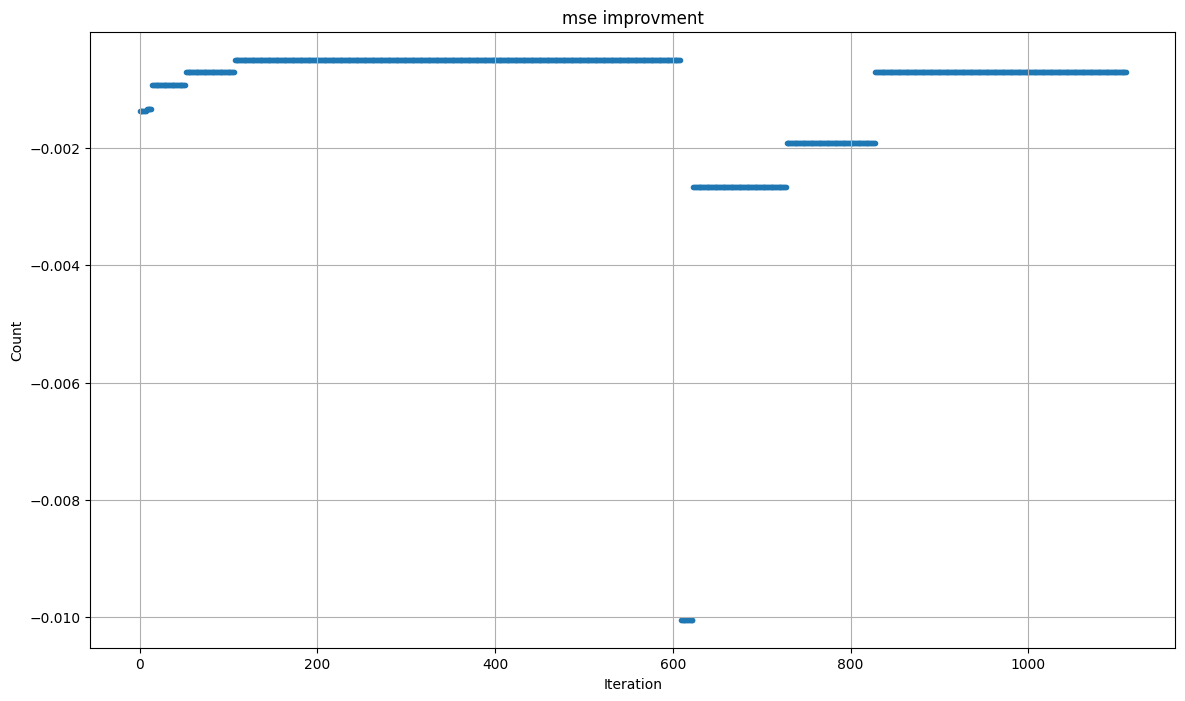

In [106]:
#from itertools import accumulate
from matplotlib import pyplot as plt

#valid = [sol.fitness for sol in list(accumulate(history, max))]
#Array of all costs only
costs = [sol.fitness[1] for sol in history]
#Plot
plt.figure(figsize=(14, 8))             
plt.title("mse improvment")
plt.grid()

plt.scatter(range(len(costs)), costs, marker=".")

plt.xlabel('Iteration')
plt.ylabel('Count')